<a href="https://colab.research.google.com/github/comparativechrono/PedNet/blob/main/pedigree_analysis_lab_book_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
pip install networkx matplotlib pandas powerlaw


simulated pedigrees- write out to file. Not for inclusion in package, but need to document.

In [64]:
# Example for Autosomal Dominant
ad_ped_data = """\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
FAM1 8 0 0 1 1
"""

# Example for Autosomal Recessive
ar_ped_data = """\
FAM2 1 0 0 1 1
FAM2 2 0 0 2 2
FAM2 3 1 2 1 1
FAM2 4 1 2 2 1
FAM2 10 0 0 1 1
FAM2 11 0 0 2 1
FAM2 5 3 11 1 2
FAM2 6 3 11 2 1
FAM2 7 4 10 2 2
FAM2 8 4 10 1 1

"""

with open("ad.ped", "w") as f:
    f.write(ad_ped_data)

with open("ar.ped", "w") as f:
    f.write(ar_ped_data)


Functions to convert pedigree to network

In [65]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def ped_to_graph(ped_file):
    cols = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype']
    df = pd.read_csv(ped_file, sep='\s+', header=None, names=cols)

    # Ensure 'Phenotype' column is treated as integer, handling potential errors
    # If there are non-numeric values in the 'Phenotype' column, this will raise an error.
    # For this specific dataset, the values are integers, so it should work.
    df['Phenotype'] = df['Phenotype'].astype(int)

    G = nx.DiGraph()

    for _, row in df.iterrows():
        # Make sure IndividualID is treated as a string or int consistently if needed
        G.add_node(str(row['IndividualID']),
                   family=row['FamilyID'],
                   sex=row['Sex'],
                   phenotype=row['Phenotype'])

    for _, row in df.iterrows():
        # Ensure PaternalID and MaternalID are compared to string '0' if they are strings
        paternal_id = str(row['PaternalID'])
        maternal_id = str(row['MaternalID'])
        individual_id = str(row['IndividualID'])

        if paternal_id != '0':
            G.add_edge(paternal_id, individual_id)
        if maternal_id != '0':
            G.add_edge(maternal_id, individual_id)

    return G


Save pedigrees as graphs - G_ad and G_ar data structures used as variable names throughout

In [66]:
G_ad = ped_to_graph("ad.ped")
G_ar = ped_to_graph("ar.ped")

Simple plot of network - not optimised, to beimproved below.

In [67]:
def plot_pedigree(G, title="Pedigree Graph"):
    pos = nx.spring_layout(G, seed=42)
    # Accessing node attributes should now be safe
    node_colors = ['red' if G.nodes[n]['phenotype'] == 2 else 'lightblue' for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True)
    plt.title(title)
    plt.show()


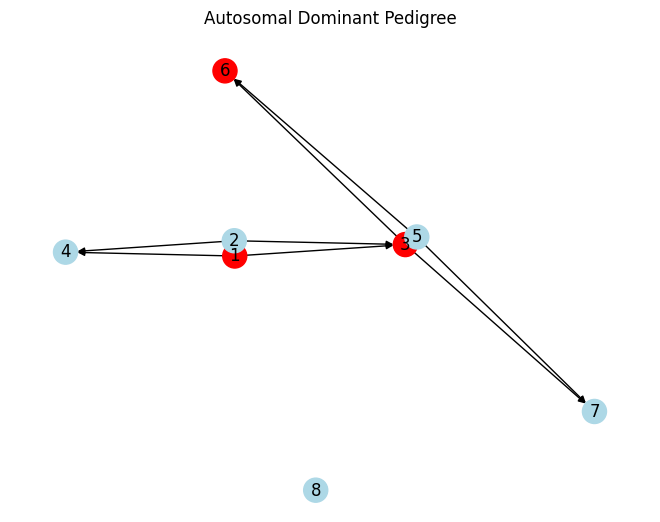

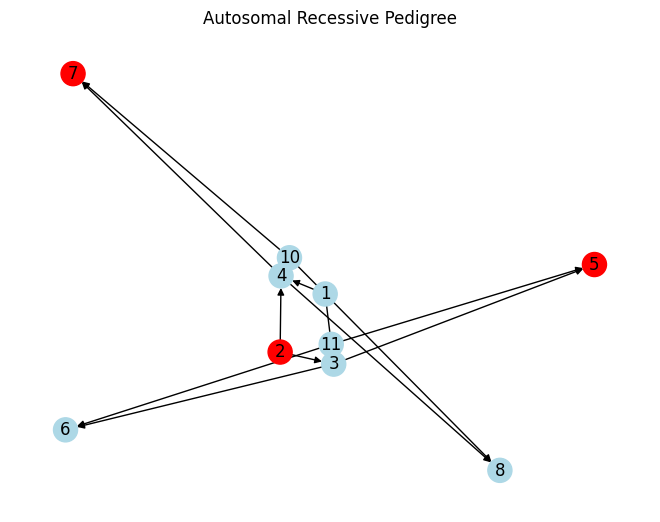

In [68]:
plot_pedigree(G_ad, "Autosomal Dominant Pedigree")
plot_pedigree(G_ar, "Autosomal Recessive Pedigree")


Some basic graph analysis

In [69]:
def analyze_graph(G):
    G_u = G.to_undirected()
    metrics = {
        "degree": dict(nx.degree(G)),
        "degree_centrality": nx.degree_centrality(G),
        "betweenness": nx.betweenness_centrality(G),
        "clustering": nx.average_clustering(G_u),
        # Check if the graph is connected before calculating diameter
        "diameter": nx.diameter(G_u) if nx.is_connected(G_u) else None
    }
    return metrics

In [70]:
results_ad = analyze_graph(G_ad)
results_ar = analyze_graph(G_ar)

print("AD Metrics:", results_ad)
print("AR Metrics:", results_ar)

AD Metrics: {'degree': {'1': 2, '2': 2, '3': 4, '4': 2, '5': 2, '6': 2, '7': 2, '8': 0}, 'degree_centrality': {'1': 0.2857142857142857, '2': 0.2857142857142857, '3': 0.5714285714285714, '4': 0.2857142857142857, '5': 0.2857142857142857, '6': 0.2857142857142857, '7': 0.2857142857142857, '8': 0.0}, 'betweenness': {'1': 0.0, '2': 0.0, '3': 0.09523809523809523, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0}, 'clustering': 0.0, 'diameter': None}
AR Metrics: {'degree': {'1': 2, '2': 2, '3': 4, '4': 4, '10': 2, '11': 2, '5': 2, '6': 2, '7': 2, '8': 2}, 'degree_centrality': {'1': 0.2222222222222222, '2': 0.2222222222222222, '3': 0.4444444444444444, '4': 0.4444444444444444, '10': 0.2222222222222222, '11': 0.2222222222222222, '5': 0.2222222222222222, '6': 0.2222222222222222, '7': 0.2222222222222222, '8': 0.2222222222222222}, 'betweenness': {'1': 0.0, '2': 0.0, '3': 0.05555555555555555, '4': 0.05555555555555555, '10': 0.0, '11': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0}, 'clustering': 0.0, '

Networkx default is a bit rubbish to be honest, isn't it! Alternative is pygraphviz. To work on colab need to install from commandline

In [71]:
!apt install graphviz libgraphviz-dev


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [72]:
pip install pygraphviz


Force networkx to plot as a DAG - need to think about whether need to adjust in the future - as anyone without kids is floating - but this doesn't matter for analysis

In [73]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_pedigree_tree(G, title="Pedigree (Tree Layout)"):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')  # 'dot' gives top-down DAG style
    except ImportError:
        print("PyGraphviz not installed. Falling back to spring layout.")
        pos = nx.spring_layout(G, seed=42)

    node_colors = ['red' if G.nodes[n]['phenotype'] == 2 else 'lightblue' for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True)
    plt.title(title)
    plt.show()


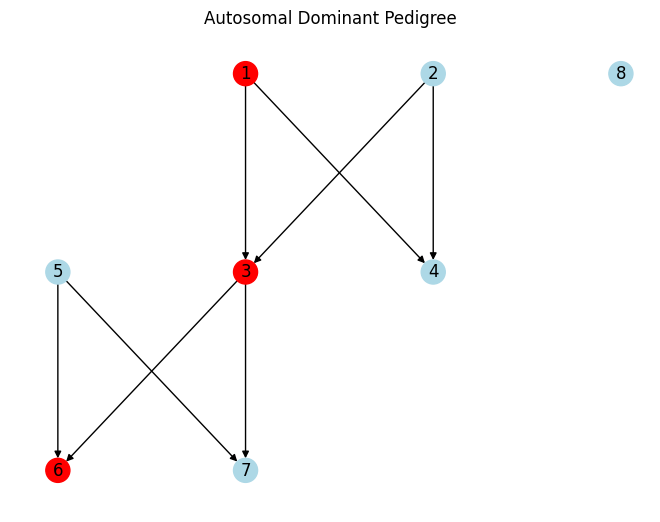

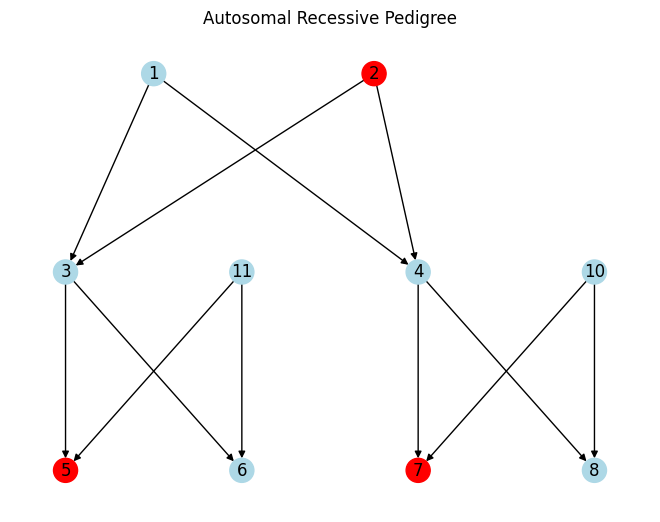

In [74]:
plot_pedigree_tree(G_ad, "Autosomal Dominant Pedigree")
plot_pedigree_tree(G_ar, "Autosomal Recessive Pedigree")

Do we need to show sex? Maybe, people like it, but if in ped file, is necessary? Could put both in the package.
Decided I actually like it with squares and circles, BUT can only be for graphing, analysis has to be done on original, as this is two different networks

In [75]:
def plot_pedigree_with_sex(G, title="Pedigree Graph with Sex Styling"):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')
    except ImportError:
        print("PyGraphviz not found, using spring layout.")
        pos = nx.spring_layout(G, seed=42)

    # Separate nodes by sex
    males = [n for n in G.nodes if G.nodes[n].get("sex") == 1]
    females = [n for n in G.nodes if G.nodes[n].get("sex") == 2]
    unknowns = [n for n in G.nodes if G.nodes[n].get("sex") not in (1, 2)]

    # Phenotype-based colors
    def node_color(n):
        return 'red' if G.nodes[n].get("phenotype") == 2 else 'lightblue'

    male_colors = [node_color(n) for n in males]
    female_colors = [node_color(n) for n in females]
    unknown_colors = [node_color(n) for n in unknowns]

    # Draw edges first (underneath)
    nx.draw_networkx_edges(G, pos, arrows=True)

    # Draw nodes by sex
    nx.draw_networkx_nodes(G, pos, nodelist=males, node_shape='s', node_color=male_colors, label='Males')
    nx.draw_networkx_nodes(G, pos, nodelist=females, node_shape='o', node_color=female_colors, label='Females')
    if unknowns:
        nx.draw_networkx_nodes(G, pos, nodelist=unknowns, node_shape='D', node_color=unknown_colors, label='Unknown')

    # Add labels
    nx.draw_networkx_labels(G, pos)

    plt.title(title)
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.show()


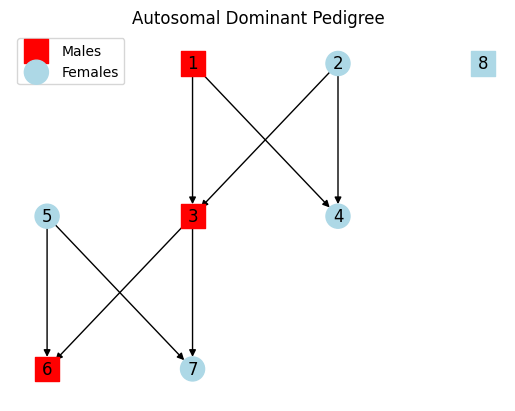

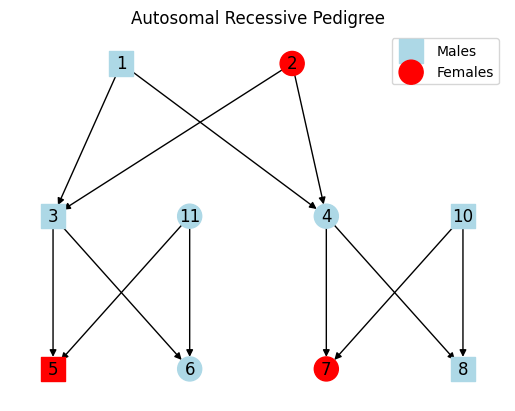

In [76]:
plot_pedigree_with_sex(G_ad, "Autosomal Dominant Pedigree")
plot_pedigree_with_sex(G_ar, "Autosomal Recessive Pedigree")

Unsure what network concepts are useful for analysis, extend to powerlaw?

Code to fit powerlaw and check distribution of degrees

In [77]:
import powerlaw

def test_powerlaw(G):
    degrees = [d for n, d in G.degree()]
    fit = powerlaw.Fit(degrees, verbose=False)
    return fit.power_law.alpha, fit.power_law.xmin

print("AD Powerlaw:", test_powerlaw(G_ad))
print("AR Powerlaw:", test_powerlaw(G_ar))


AD Powerlaw: (np.float64(11.098865286222745), np.float64(2.0))
AR Powerlaw: (np.float64(8.213475204444817), np.float64(2.0))


In [78]:
import matplotlib.pyplot as plt

def plot_degree_distribution(G, title="Degree Distribution"):
    degrees = [d for n, d in G.degree()]
    fit = powerlaw.Fit(degrees, verbose=False)

    fig = fit.plot_pdf(color='b', label='Empirical')
    fit.power_law.plot_pdf(color='r', linestyle='--', label='Power law fit', ax=fig)
    plt.legend()
    plt.title(title + f"\nα = {fit.power_law.alpha:.2f}, xmin = {fit.power_law.xmin}")
    plt.xlabel("Degree")
    plt.ylabel("P(Degree ≥ x)")
    plt.show()

    R, p = fit.distribution_compare('power_law', 'exponential')
    print("Comparison with exponential: R =", R, "p =", p)


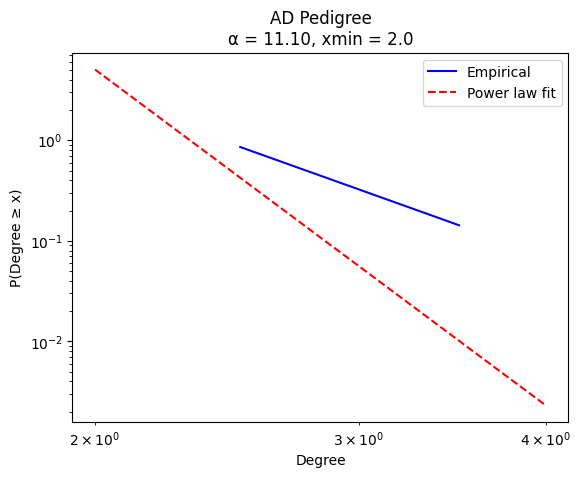

Comparison with exponential: R = 1.8724432635117032 p = 0.0035250216114520653


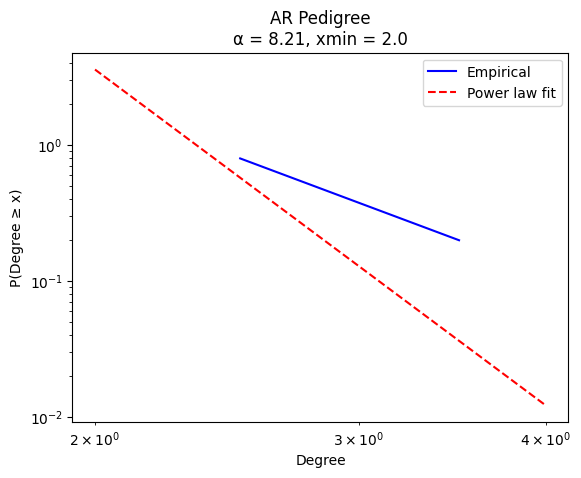

Comparison with exponential: R = 2.2788348446967532 p = 0.009346135413736271


In [79]:
plot_degree_distribution(G_ad, "AD Pedigree")
plot_degree_distribution(G_ar, "AR Pedigree")


R > 0 and p < 0.05: power law is significantly better

R ≈ 0 or p > 0.05: either no clear winner, or exponential is better

This code is probably good as is, works quite well.

#Development of code to call inheritance patterns

Functions to do the jobs needed - have formatted these correctly! :)

In [80]:
import networkx as nx
from collections import defaultdict, Counter

# ---------------------------------------------------------------------------
# 0.  Helpers
# ---------------------------------------------------------------------------

def founders(G):
    """Return founder nodes (no incoming edges = no known parents)."""
    return [n for n in G.nodes if G.in_degree(n) == 0]

def get_generation_levels(G):
    """
    Assign each node a generation level (founders = 0).
    Works even if multiple founders exist in one pedigree.
    Returns a dict {node: level}.
    """
    levels = {}
    queue = [(f, 0) for f in founders(G)]
    while queue:
        node, lvl = queue.pop(0)
        if node in levels and levels[node] <= lvl:
            continue
        levels[node] = lvl
        for child in G.successors(node):          # parent → child
            queue.append((child, lvl + 1))
    return levels

def parents(G, node):
    """Return list of parent nodes for a given node."""
    return list(G.predecessors(node))

def siblings(G, node):
    """Return siblings of node (share ≥ 1 parent)."""
    sibs = set()
    for p in parents(G, node):
        sibs.update(G.successors(p))
    sibs.discard(node)
    return sibs

# ---------------------------------------------------------------------------
# 1.  Feature extraction
# ---------------------------------------------------------------------------

def pedigree_features(G):
    """
    Compute graph-theoretic and pedigree-specific features that differ
    between AD and AR modes.  Returns a dict of feature values.
    """
    phen = nx.get_node_attributes(G, "phenotype")
    is_aff = {n: (phen.get(n) == 2) for n in G}      # bool map

    # --- 1. ratio of affected individuals with ≥1 affected parent
    aff_nodes = [n for n, a in is_aff.items() if a]
    aff_with_aff_parent = sum(
        any(is_aff.get(p, False) for p in parents(G, n)) for n in aff_nodes
    )
    ratio_aff_parent = (aff_with_aff_parent / len(aff_nodes)) if aff_nodes else 0

    # --- 2. generation coverage: proportion of generations that contain >=1 affected
    gen_levels = get_generation_levels(G)
    if gen_levels:
        max_gen = max(gen_levels.values())
        gens_aff = {gen_levels[n] for n in aff_nodes}
        generation_coverage = len(gens_aff) / (max_gen + 1)
    else:
        generation_coverage = 0

    # --- 3. sibling clustering: fraction of affected-affected sibling pairs
    aa_sib_pairs = 0
    total_aff_pairs = 0
    checked = set()
    for n in aff_nodes:
        for sib in siblings(G, n):
            if sib in aff_nodes and (sib, n) not in checked:
                aa_sib_pairs += 1
            if (sib, n) not in checked:
                total_aff_pairs += 1
            checked.add((n, sib))
            checked.add((sib, n))
    sibling_aff_ratio = (aa_sib_pairs / total_aff_pairs) if total_aff_pairs else 0

    # --- 4. betweenness of parents whose children are affected but they are not
    bet = nx.betweenness_centrality(G)
    carrier_like = [
        bet[p]
        for n in aff_nodes
        for p in parents(G, n)
        if not is_aff.get(p, False)
    ]
    avg_carrier_betweenness = sum(carrier_like) / len(carrier_like) if carrier_like else 0

    # --- 5. simple global measures
    G_u = G.to_undirected()
    avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()

    return dict(
        ratio_aff_parent=ratio_aff_parent,
        generation_coverage=generation_coverage,
        sibling_aff_ratio=sibling_aff_ratio,
        avg_carrier_betweenness=avg_carrier_betweenness,
        avg_degree=avg_degree,
        n_affected=len(aff_nodes),
    )

# ---------------------------------------------------------------------------
# 2.  Rule-based classifier
# ---------------------------------------------------------------------------

def classify_inheritance(G, verbose=True):
    """
    Return 'AD', 'AR', or 'Uncertain', plus the feature vector.
    Thresholds chosen from simulated pedigrees; tweak as desired.
    """
    feats = pedigree_features(G)

    # heuristic thresholds
    if feats["ratio_aff_parent"] >= 0.75 and feats["generation_coverage"] >= 0.75:
        mode = "AD"
    elif (
        feats["ratio_aff_parent"] <= 0.25
        and feats["sibling_aff_ratio"] >= 0.40
    ):
        mode = "AR"
    else:
        mode = "Uncertain"

    if verbose:
        print("Feature summary:", {k: round(v, 3) for k, v in feats.items()})
        print("→ Classified as", mode)

    return mode, feats


Rationale for rules (could almost certainly be better formulated)

| Feature                   | AD expectation              | AR expectation         | Biological intuition                                                    |
| ------------------------- | --------------------------- | ---------------------- | ----------------------------------------------------------------------- |
| `ratio_aff_parent`        | **High** (≥ 0.75)           | **Low** (≤ 0.25)       | Dominant traits almost always come from an affected parent.             |
| `generation_coverage`     | **High** (every generation) | **Low/medium** (skips) | Dominant shows vertical transmission.                                   |
| `sibling_aff_ratio`       | **Low**                     | **High**               | Recessive traits cluster among siblings from carrier parents.           |
| `avg_carrier_betweenness` | **Low**                     | **Elevated**           | Carrier parents sit on many shortest paths linking affected sibs in AR. |
| `avg_degree`              | Similar (sanity check)      | Similar                | Just a control metric (optional).                                       |


Function test

In [81]:
mode_ad, feats_ad = classify_inheritance(G_ad)
mode_ar, feats_ar = classify_inheritance(G_ar)

Feature summary: {'ratio_aff_parent': 0.667, 'generation_coverage': 1.0, 'sibling_aff_ratio': 0.0, 'avg_carrier_betweenness': 0.0, 'avg_degree': 2.0, 'n_affected': 3}
→ Classified as Uncertain
Feature summary: {'ratio_aff_parent': 0.0, 'generation_coverage': 1.0, 'sibling_aff_ratio': 0.0, 'avg_carrier_betweenness': 0.028, 'avg_degree': 2.4, 'n_affected': 3}
→ Classified as Uncertain


Needs some work - adjust ratios etc. need to build in rules for X-linked.

Also - the dictionary returned by pedigree_features is tabular-friendly - could stick into Machine Learning approach. Need lots of pedigrees to train and test on. Ask Marc!

# Incorporating VCF files

In [82]:
def affected_nodes(G):
    phen = nx.get_node_attributes(G, "phenotype")
    return [n for n, p in phen.items() if p == 2]

def unaffected_nodes(G):
    phen = nx.get_node_attributes(G, "phenotype")
    return [n for n, p in phen.items() if p != 2]


VCF simulator helper function

In [83]:
import random

def simulate_variant_table(G, mode="AD", n_background=5, seed=1):
    """
    Returns dict:
        variant_id -> { sample_id : genotype }
    Genotype encodings:
        0 : hom-ref (0/0)
        1 : het     (0/1)
        2 : hom-alt (1/1)
    """
    random.seed(seed)
    samples = list(G.nodes)
    phen = nx.get_node_attributes(G, "phenotype")

    variants = {}

    # -- 1. causal variant
    var_id = "chr1:100000_A>T"
    gt = {s: 0 for s in samples}

    if mode == "AD":
        for s in samples:
            if phen[s] == 2:
                gt[s] = 1                        # heterozygous alt
        # force at least one founder carrier
        any_aff = affected_nodes(G)[0]
        gt[random.choice(parents(G, any_aff) or [any_aff])] = 1

    elif mode == "AR":
        for s in samples:
            if phen[s] == 2:
                gt[s] = 2                        # homo-alt in affected
                for p in parents(G, s):
                    gt[p] = 1                    # carriers
    variants[var_id] = gt

    # -- 2. random background variants
    for i in range(n_background):
        var_id = f"chr1:{100100+i}_G>C"
        gt = {s: random.choices([0,1,2], [0.8,0.18,0.02])[0] for s in samples}
        variants[var_id] = gt

    return variants


In [84]:
def variants_to_vcf(variants, samples):
    header  = "##fileformat=VCFv4.2\n"
    header += "##FORMAT=<ID=GT,Number=1,Type=String,Description=\"Genotype\">\n"
    header += "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t" + "\t".join(samples) + "\n"

    rows = []
    for vid, gt_dict in variants.items():
        # vid = "chr1:100000_A>T"
        chrom, rest = vid.split(":")          # "chr1", "100000_A>T"
        pos, mut   = rest.split("_")          # "100000", "A>T"
        ref, alt   = mut.split(">")           # "A", "T"

        gts = [{0:"0/0", 1:"0/1", 2:"1/1"}[gt_dict[s]] for s in samples]
        row = f"{chrom}\t{pos}\t.\t{ref}\t{alt}\t.\t.\t.\tGT\t" + "\t".join(gts)
        rows.append(row)

    return header + "\n".join(rows)


In [85]:
vcf_text_AD = variants_to_vcf(vars_AD, list(G_ad.nodes))
print(vcf_text_AD[:300], "...")

##fileformat=VCFv4.2
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	1	2	3	4	5	6	7	8
chr1	100000	.	A	T	.	.	.	GT	0/1	0/0	0/1	0/0	0/0	0/1	0/0	0/0
chr1	100100	.	G	C	.	.	.	GT	0/0	0/1	0/0	0/0	0/0	0/0	0/0	0/0
chr1	100101	.	G	C	.	.	.	GT	0/0	0/1	0/0 ...


Functions to see if varaints segregate: basic ones, simple rules

In [86]:
def segregation_score(G, gt_dict):
    aff = affected_nodes(G)
    unaff = unaffected_nodes(G)
    if not aff:
        return 0
    alt_aff = sum(gt_dict[n] > 0 for n in aff) / len(aff)
    alt_unaff = sum(gt_dict[n] > 0 for n in unaff) / len(unaff) if unaff else 0
    return alt_aff - alt_unaff

def scan_variants(G, variants):
    scores = {vid: segregation_score(G, gt) for vid, gt in variants.items()}
    top = max(scores, key=scores.get)
    return top, scores[top], scores


To run, ideally need logic in the pipeline so that we identify phenotype pattern, and get a label as either AD or AR, and can then apply to pedigrees. Here I have just used the labels nominally assign.

In [87]:
for label, G in [("AD", G_ad), ("AR", G_ar)]:
    vars_dict = simulate_variant_table(G, mode=label)
    best_var, best_score, all_scores = scan_variants(G, vars_dict)
    print(f"\n{label} pedigree → best-segregating variant:")
    print("  ", best_var, "score =", round(best_score,3))
    # Optional: print sorted scores
    for vid, sc in sorted(all_scores.items(), key=lambda x: -x[1]):
        print("   •", vid, round(sc,3))



AD pedigree → best-segregating variant:
   chr1:100000_A>T score = 1.0
   • chr1:100000_A>T 1.0
   • chr1:100104_G>C 0.267
   • chr1:100103_G>C 0.133
   • chr1:100100_G>C -0.2
   • chr1:100102_G>C -0.2
   • chr1:100101_G>C -0.4

AR pedigree → best-segregating variant:
   chr1:100104_G>C score = 0.857
   • chr1:100104_G>C 0.857
   • chr1:100000_A>T 0.429
   • chr1:100100_G>C 0.333
   • chr1:100103_G>C 0.333
   • chr1:100101_G>C 0.048
   • chr1:100102_G>C -0.143


Ideas for how we can apply graph theory on the network to use genotypes

| Component                       | Why it matters                                                                                                                               | How it’s measured                                                                                                                                            |
| ------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Edge consistency penalty**    | Incompatible parent → child genotype transitions (e.g. recessive child with no carrier parent).                                              | Traverse every edge and deduct points for impossible or unlikely transitions under the hypothesised mode (AD / AR).                                          |
| **Generation-continuity bonus** | Dominant traits should appear every generation; recessive traits cluster within a generation.                                                | Reward AD if ≥ 75 % of generations that have any samples also have ≥ 1 alt-allele carrier; reward AR if most carriers are confined to ≤ 50 % of generations. |
| **Carrier-betweenness signal**  | In AR, the (unaffected) carrier parents of affected sibs often lie on many shortest paths between affected nodes; in AD they usually do not. | Compute betweenness of all heterozygous, unaffected nodes and scale it by the number of affected-affected shortest paths they mediate.                       |


In [88]:
## helper function I made before, but then deleted, and is needed for the below.

def generations(G):
    lvl, Q = {}, [(n,0) for n in G if G.in_degree(n)==0]
    while Q:
        node, g = Q.pop(0)
        if node in lvl:          continue
        lvl[node] = g
        Q.extend((c,g+1) for c in G.successors(node))
    return lvl

In [89]:
import networkx as nx
from collections import defaultdict
from math import sqrt

# -----------------------------------------------------------------------------
# 1.  edge-transition penalty tables
# -----------------------------------------------------------------------------
# codes: 0 hom-ref, 1 het, 2 hom-alt
_ALLOWED = {
    "AD": {
        # parent genotype(s) set → allowed child genotypes
        (0,0): {0},                   # two non-carriers → unaffected only
        (1,0): {0,1}, (0,1): {0,1},
        (1,1): {0,1,2},
        (2, _): {1,2}, (_,2): {1,2}, # any parent hom-alt → child at least het
    },
    "AR": {
        (0,0): {0},
        (1,0): {0,1}, (0,1): {0,1},
        (1,1): {0,1,2},
        (2,_): {1,2}, (_,2): {1,2},  # hom-alt parent forces child ≥ het
    }
}
def allowed_child_set(mode, gp, gm):
    # normalise order to lookup
    key = (gp, gm) if (gp,gm) in _ALLOWED[mode] else (gm, gp)
    # wild card look-up
    if key not in _ALLOWED[mode]:
        if (gp==2 or gm==2):
            key = (2,"_")
        else:
            key = (1,"_")            # fallback
    return _ALLOWED[mode].get(key, {0,1,2})

# -----------------------------------------------------------------------------
# 2.  core function
# -----------------------------------------------------------------------------
def segregation_network_score(G, gt_dict, mode="AD", w_edge=0.6,
                              w_gen=0.2, w_bet=0.2):
    """
    Composite score in [-1,1].  Positive = good fit, negative = inconsistent.
    tunable weights sum to 1.
    """
    pheno = nx.get_node_attributes(G, "phenotype")
    # -------------------------------- edge consistency
    total_edges, bad_edges = 0, 0
    for c in G.nodes:
        parent_gts = [gt_dict.get(p,0) for p in parents(G,c)] + [0,0]
        gp, gm = parent_gts[0], parent_gts[1]
        allowed = allowed_child_set(mode, gp, gm)
        if gt_dict[c] not in allowed:
            bad_edges += 1
        total_edges += 1
    edge_penalty = 1 - (bad_edges / total_edges)          # 1=perfect
    # -------------------------------- generation continuity / confinement
    gen = generations(G)
    gens_total = max(gen.values()) + 1
    alt_by_gen = defaultdict(int)
    for n,g in gen.items():
        if gt_dict[n] > 0:
            alt_by_gen[g] += 1
    gens_with_alt = len([g for g,cnt in alt_by_gen.items() if cnt])
    if mode == "AD":
        gen_score = gens_with_alt / gens_total            # want ~1.0
    else:  # AR
        gen_score = 1 - (gens_with_alt / gens_total)      # want small
    # scale to [0,1]
    gen_score = max(0, min(1, gen_score))
    # -------------------------------- carrier betweenness
    het_carriers = [n for n in G if gt_dict[n]==1 and pheno[n]!=2]
    if het_carriers:
        bet = nx.betweenness_centrality(G)
        # normalise: divide by theoretical max betweenness in graph
        max_bet = max(bet.values()) or 1
        carrier_bet = sum(bet[n] for n in het_carriers)/len(het_carriers)
        bet_score_raw = carrier_bet / max_bet
        bet_score = bet_score_raw if mode=="AR" else (1 - bet_score_raw)
    else:
        bet_score = 0 if mode=="AR" else 1
    # -------------------------------- combine
    total = (w_edge*edge_penalty +
             w_gen*gen_score +
             w_bet*bet_score)
    components = dict(edge_penalty=round(edge_penalty,3),
                      gen_score=round(gen_score,3),
                      bet_score=round(bet_score,3))
    return round(total,3), components

# -----------------------------------------------------------------------------
# 3.  scan wrapper  (returns best variant, like before)
# -----------------------------------------------------------------------------
def scan_variants_network(G, variants, mode="AD"):
    scores = {}
    for vid, gt in variants.items():
        s, comp = segregation_network_score(G, gt, mode=mode)
        scores[vid] = (s, comp)
    best = max(scores, key=lambda v: scores[v][0])
    return best, scores[best], scores


Edge penalty ≈ 1 for the true causal variant, lower for random ones.

Generation score near 1 for AD causal, near 0 (penalised) for AR causal, and vice-versa.

Betweenness score positive for AR carriers, “flipped” for AD.

In [90]:
variants_AD = simulate_variant_table(G_ad, mode="AD")
best, detail, all_scores = scan_variants_network(G_ad, variants_AD, mode="AD")
print("Best variant:", best)
print("Composite score:", detail[0])
print("Component details:", detail[1])


Best variant: chr1:100000_A>T
Composite score: 0.925
Component details: {'edge_penalty': 0.875, 'gen_score': 1, 'bet_score': 1}


In [91]:
variants_AR = simulate_variant_table(G_ar, mode="AR")
best, detail, all_scores = scan_variants_network(G_ar, variants_AR, mode="AR")
print("Best variant:", best)
print("Composite score:", detail[0])
print("Component details:", detail[1])


Best variant: chr1:100102_G>C
Composite score: 0.84
Component details: {'edge_penalty': 0.9, 'gen_score': 0.5, 'bet_score': 1.0}
